# requirements

In [ ]:
import pandas as pd
import os
import scipy.io as sio
import numpy as np
import random
from random import randrange, shuffle, random, randint
import re

import math
import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm.auto import tqdm

from datetime import datetime

# Config Hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# File path of the input [change this according to your bioscan folder path]
bioscan_folder_path = "/content/drive/MyDrive/BIOSCAN"
  #"/content/drive/MyDrive/University_of_Waterloo/BIOSCAN" #Monireh BIOSCAN path
  #"/content/drive/MyDrive/BIOSCAN" # Niousha's path

input_path = f"{bioscan_folder_path}/small_training.tsv"
# input_path = f"{bioscan_folder_path}/medium_training.tsv"
# input_path = f"{bioscan_folder_path}/full_training.tsv"


# nameOfDataset_epochs_maxLength
experiments_name = "small_new_dataloader" #"medium_dataset_1000_512"


config = {
    "d_model": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "max_len" : 512

}

saving_path = f"{bioscan_folder_path}/model_checkpoints/{experiments_name}"
Path(saving_path).mkdir(parents=True, exist_ok=True)

epoch_loss_list = []
training_epoch = 1000
continue_epoch = 0




# Load data and tokenize

In [ ]:
class PabloDNADataset:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, sep="\t", encoding="unicode_escape")

    def clean_nan(self, col_names, replace_orig=False):
        clean_df = self.df.dropna(subset=col_names)
        clean_df = clean_df.reset_index(drop=True)
        if replace_orig:
            self.df = clean_df
        return clean_df
    
    def change_RXY2N(self, col_names, replace_orig=False):
      full_pattern = re.compile('[^ACGTN\-]') 
      self.df[col_names] = self.df[col_names].apply(lambda x: re.sub(full_pattern, 'N', x))
      # if replace_orig:
      #   self.df[col_names] = clean_nucleotides
      # return clean_str_df


    def generate_mini_sample(self, dataframe=None, bin_count=20, output_path="mini_sample.tsv"):
        if dataframe is None:
            dataframe = self.df
        bins = list(dataframe['bin_uri'].unique())
        rd1 = random.sample(range(0, len(bins)), bin_count)
        bins = [bins[i] for i in rd1]
        mini_df = dataframe.loc[dataframe['bin_uri'].isin(bins)]
        mini_df = mini_df.reset_index(drop=True)
        # mini_df = dataframe.iloc[0:sample_count]
        # mini_df = dataframe.take(np.random.permutation(len(dataframe))[:sample_count])
        mini_df.to_csv(output_path, sep="\t")

    def get_info(self, dataframe=None):
        if dataframe is None:
            dataframe = self.df
        print("Total data: ", len(dataframe))
        print("Number of bin clusters: ", len(dataframe['bin_uri'].unique()))



In [ ]:
def tokenizer(dna_sentence, k_mer_dict, k_mer_length, stride=1):
    tokens = []
    for i in range(0, len(dna_sentence) - k_mer_length + 1, stride):
        k_mer = dna_sentence[i:i + k_mer_length]
        tokens.append(k_mer_dict[k_mer])
    return tokens



class SampleDNAData(Dataset):
    """Barcode Dataset"""
    @staticmethod
    def get_all_kmers(k_mer_length, alphabet=None) -> list:
        """
        :rtype: object
        """

        def base_convert(num, base, length):
            result = []
            while num > 0:
                result.insert(0, num % base)
                num = num // base
            while len(result) < length:
                result.insert(0, 0)
            return result

        if alphabet is None:
            alphabet = ["A", "C", "G", "T", "-", "N"]
        k_mer_counts = len(alphabet) ** k_mer_length
        all_k_mers_list = []
        for i in range(k_mer_counts):
            code = base_convert(num=i, base=len(alphabet), length=k_mer_length)
            k_mer = ""
            for j in range(k_mer_length):
                k_mer += alphabet[code[j]]
            all_k_mers_list.append(k_mer)

        return all_k_mers_list

    def _generate_processed_data(self, dna_a, dna_b, label):
        rand_len = randrange(128, 256)

        dna_a = dna_a[0:len(dna_a) // 2][0:rand_len]
        dna_b = dna_b[len(dna_b) // 2:][0:rand_len]
        tokens_a = tokenizer(dna_a, self.word_dict, self.k_mer, stride=1)
        tokens_b = tokenizer(dna_b, self.word_dict, self.k_mer, stride=1)

        input_ids = [self.word_dict['[CLS]']] + tokens_a + [self.word_dict['[SEP]']] + tokens_b + [
            self.word_dict['[SEP]']]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # MASK LM  (15 % of tokens in one sentence)
        n_pred = min(self.max_mask_count, max(1, int(round(len(input_ids) * 0.15)))) // self.k_mer

        cand_masked_pos = [i for i, token in enumerate(input_ids)
                           if token != self.word_dict['[CLS]'] and token != self.word_dict['[SEP]']]

        # remove N and gaps from cand_masked_pos
        cand_masked_pos_copy = cand_masked_pos.copy()
        for position in cand_masked_pos_copy:
            remove_flag = False
            for s in range(self.k_mer):
                if position + s < len(input_ids):
                    key = self.number_dict[input_ids[position + s]]
                    if ("N" in key) or ("-" in key):
                        remove_flag = True
                        break
            if remove_flag:
                cand_masked_pos.remove(position)

        shuffle(cand_masked_pos)

        # if the position remains is less than 15%, mask them all
        if len(cand_masked_pos) < n_pred:
            n_pred = len(cand_masked_pos)

        masked_tokens, masked_pos = [], []
        for pos in cand_masked_pos[:n_pred]:
            for s in range(self.k_mer):
                if pos + s < len(input_ids):
                    masked_pos.append(pos + s)
                    masked_tokens.append(input_ids[pos + s])
                    input_ids[pos + s] = self.word_dict['[MASK]']  # make mask

        # Zero Paddings
        n_pad = self.max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if self.max_mask_count > len(masked_pos):
            n_pad = self.max_mask_count - len(masked_pos)
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        return [input_ids, segment_ids, masked_tokens, masked_pos, label]

    def __init__(self, file_path, k_mer=4, max_mask_count=5, max_len=256):
        self.k_mer = k_mer
        self.max_mask_count = max_mask_count
        self.max_len = max_len
        pablo_dataset = PabloDNADataset(file_path)
        # for removing X,R,Y letters from data
        pablo_dataset.change_RXY2N("nucleotides")
        self.dna_nucleotides = list(pablo_dataset.df["nucleotides"].values)
        self.data_count = len(self.dna_nucleotides)
        word_list = SampleDNAData.get_all_kmers(self.k_mer)

        number_dict = dict()
        word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
        for i, w in enumerate(word_list):
            word_dict[w] = i + 4
            number_dict = {i: w for i, w in enumerate(word_dict)}

        self.word_dict = word_dict
        self.number_dict = number_dict

        self.vocab_size = len(word_dict)
        self.max_len = max_len

        self.batch = []

        for data_index in range(self.data_count):
            dna_a = self.dna_nucleotides[data_index]

            tokens_b_index = data_index
            while data_index == tokens_b_index:
                tokens_b_index = randrange(len(self.dna_nucleotides))
            dna_b = self.dna_nucleotides[tokens_b_index]

            self.batch.append(self._generate_processed_data(dna_a=dna_a, dna_b=dna_a, label=True))
            self.batch.append(self._generate_processed_data(dna_a=dna_a, dna_b=dna_b, label=False))

    def __len__(self):
        return len(self.batch)

    def __getitem__(self, idx):
        ids = torch.Tensor(self.batch[idx][0])
        seg = torch.Tensor(self.batch[idx][1])
        msk_tok = torch.Tensor(self.batch[idx][2])
        msk_pos = torch.Tensor(self.batch[idx][3])
        label = torch.Tensor([self.batch[idx][4]])

        ids, seg, msk_pos = ids.type(torch.IntTensor), seg.type(torch.IntTensor), msk_pos.type(torch.int64)

        msk_tok = msk_tok.type(torch.LongTensor)
        label = label.type(torch.LongTensor)

        return ids, seg, msk_pos, msk_tok, label

# Model

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(int(vocab_size), int(d_model))  # token embedding
        self.pos_embed = nn.Embedding(int(maxlen), int(d_model))  # position embedding
        self.seg_embed = nn.Embedding(int(n_segments), int(d_model))  # segment(token type) embedding
        self.norm = nn.LayerNorm(int(d_model))
        self.device = device

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    pad_attn_mask = pad_attn_mask.to(device)
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k


class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_k)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)  # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs)  # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)

        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.d_model = d_model

        self.linear = nn.Linear(self.n_heads * self.d_v, self.d_model)

        self.layernorm = nn.LayerNorm(self.d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)  # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)  # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)

        return self.layernorm(output + residual), attn  # output: [batch_size x len_q x d_model]


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.l1 = nn.Linear(d_model, d_ff)
        self.l2 = nn.Linear(d_ff, d_model)

        self.relu = GELU()
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs
        output = self.l1(inputs)
        output = self.relu(output)
        output = self.l2(output)
        return self.layer_norm(output + residual)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        self.d_k = d_k
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(
            self.d_k)  # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9)  # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, n_layers, d_k, d_v, n_heads, device):
        super(BERT, self).__init__()
        self.embedding = Embedding(vocab_size, d_model, maxlen, n_segments, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_k, d_v, n_heads) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = GELU()
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device=device
        self.to(self.device)

    
    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            # embedding layer
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # classifier pos/neg (it will be decided by first token(CLS))
        h_pooled = self.activ1(self.fc(output[:, 0]))  # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled)  # [batch_size, 2]

        # classifier mask
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))  # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos)  # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias  # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf, output

    def get_embeddings(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            # embedding layer
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

# Train


In [ ]:
# dataloader to get a batch of data
print("loading the dataset is started")
dataset = SampleDNAData(file_path=input_path, k_mer=4, max_mask_count=80, max_len=config["max_len"])
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
# Bert model
print("data is loaded and now model is loading")
model = BERT(dataset.vocab_size, config["d_model"], dataset.max_len, 2, config["n_layers"], 32, 32, config["n_heads"], device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


loading the dataset is started
20000
data is loaded and now model is loading


In [ ]:
''' 
If you lost your connection and want to continue the training process, 
uncomment this part, load your last model, optimizer, and loss, 
choose the epoch you 
want to continue from
'''
# continue_epoch = 100
# model.load_state_dict(torch.load(saving_path + f'/model_{continue_epoch}.pth'))
# optimizer.load_state_dict(torch.load(saving_path + f"/optimizer_{continue_epoch}.pth"))

# a_file = open(saving_path + "/loss.pkl", "rb")
# epoch_loss_list = pickle.load(a_file)

' \nIf you lost your connection and want to continue the training process, \nuncomment this part, load your last model, optimizer, and loss, \nchoose the epoch you \nwant to continue from\n'

In [ ]:
# strat training
print("Training is started")
for epoch in range(continue_epoch, training_epoch + 1):
    start = datetime.now()
    epoch_loss = 0
    for ids, seg, msk_pos, masked_tokens, is_pos in dataloader:
        ids = ids.to(device)
        seg = seg.to(device)
        msk_pos = msk_pos.to(device)
        masked_tokens = masked_tokens.to(device)
        is_pos = is_pos.to(device)

        optimizer.zero_grad()
        logits_lm, logits_clsf, outputs= model(ids, seg, msk_pos)

        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens)  # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, torch.squeeze(is_pos))  # for sentence classification
        loss = loss_lm + loss_clsf

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    epoch_loss_list.append(epoch_loss)

    print(f"epoch {epoch}: Loss is {epoch_loss}, Consumption Time is {datetime.now() - start}")

    # every 50 epoch save the checkpoints and save the loss in a list
    if epoch % 50 == 0:
        torch.save(model.state_dict(), saving_path + "/model_" + str(epoch) +'.pth')
        torch.save(optimizer.state_dict(), saving_path + "/optimizer_" + str(epoch) +'.pth')

        a_file = open(saving_path + "/loss.pkl", "wb")
        pickle.dump(epoch_loss_list, a_file)
        a_file.close()


Training is started
epoch 0: Loss is 27796.743503570557
epoch 1: Loss is 24463.785129070282


## Plot the loss after training

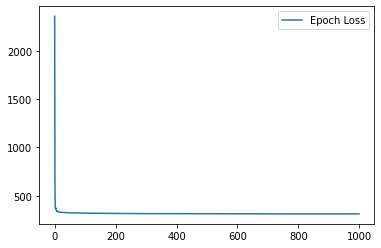

In [ ]:
plt.plot(epoch_loss_list, label ="Epoch Loss")
plt.legend(loc='upper right')
plt.savefig(f'{saving_path}/loss_per_epoch.png')
plt.show()

# Test

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82827 sha256=8f4c9346e4070b8541aafa520ddad8ab2038c293980e11841e1ef16cc53f581d
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55510 sha256=8ba3b56b63a69b2419fcd24693b3ff418c3defbed97d9ecbf892a5d56e6ae42b
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [ ]:
class test_DNA_Data(Dataset):
    """Barcode Dataset"""

    def __init__(self, file_path, k_mer=4, max_len=512):
        pablo_dataset = PabloDNADataset(file_path)
        # for removing X,R,Y letters from data
        pablo_dataset.change_RXY2N("nucleotides")
        self.dna_nucleotides = list(pablo_dataset.df["nucleotides"].values)
        self.species = list(pablo_dataset.df["species_name"].values)
        word_list = SampleDNAData.get_all_kmers(k_mer)

        word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
        for i, w in enumerate(word_list):
            word_dict[w] = i + 4
            number_dict = {i: w for i, w in enumerate(word_dict)}  # TODO: try move this out from the loop.

        
        self.word_dict = word_dict
        self.number_dict = number_dict
        self.vocab_size = len(word_dict)
        self.max_len = max_len

        self.IDS = []
        self.SEGMENTS = []
        self.SPECIES = []

        for seq, species in zip(self.dna_nucleotides, self.species):
          if len(seq) > (self.max_len - 2):
              seq = seq[:self.max_len - 2]
          tokens = tokenizer(seq, word_dict, 4, stride=1)
          input_ids = [word_dict['[CLS]']] + tokens + [word_dict['[SEP]']]
          segment_ids = [0] * (1 + len(tokens) ) + [1] * (1)
          masked_tokens, masked_pos = [], [] # No mask for testing
            
          # Zero Paddings
          n_pad = max_len - len(input_ids)
          if n_pad > 0:
            input_ids.extend([0] * n_pad)
            segment_ids.extend([0] * n_pad)

          self.IDS.append(input_ids)
          self.SEGMENTS.append(segment_ids)
          self.SPECIES.append(species)

    def __len__(self):
        return len(self.dna_nucleotides)

    def __getitem__(self, idx):
        ids = torch.Tensor(self.IDS[idx])
        seg = torch.Tensor(self.SEGMENTS[idx])
        # msk_pos = torch.Tensor([])
        label = self.SPECIES[idx]

        ids, seg = ids.type(torch.IntTensor), seg.type(torch.IntTensor) # [msk_pos.type(torch.int64)]

        return  {'input':[ids, seg], 'label':label}

  
test_path = f"{bioscan_folder_path}/unseen.tsv"
test_dataset = test_DNA_Data(test_path, max_len=config["max_len"])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# DNABERT configuration
# config = {
#     "d_model": 768,
#     "n_heads": 12,
#     "n_layers": 12,
#     "max_len":512
# }

# model = BERT(len(test_dataset.word_dict), config["d_model"], config['max_len'], 2, config["n_layers"], 32, 32, config["n_heads"])

# # Load the last model available from training

last_epoch = 1000

model.load_state_dict(torch.load(saving_path + f'/model_{last_epoch}.pth'))

<All keys matched successfully>

## Embedding [CLS]

In [ ]:
# This is not the most efficient way to do this - We should have a batch and
# a dataloader for testing. Sorry for now :( [Niousha added test dataloader ^_^]
from tqdm import tqdm


data_embeddings = []
data_labels = []

for i_batch, sample_batched in enumerate(test_dataloader):
  ids, seg = sample_batched['input']
  label_tensor = sample_batched['label']
  ids = ids.to(device)
  seg = seg.to(device)
  
  with torch.no_grad():
    out = model.get_embeddings(ids, seg)
    
    cls_embeddings = out[:,0,:]

    for i in tqdm(range(cls_embeddings.shape[0])):
      data_embeddings.append(cls_embeddings[i].cpu().numpy())
      data_labels.append(label_tensor[i])
    # print(cls_embeddings.shape)
    # print(label_tensor)
    # break
    # z1 = torch.squeeze(torch.mean(out[-1], 0, False)).cpu().numpy()
    # z2 = out[-1][:, 0].cpu().numpy()

    # embedding.append(z1)  #GAP to compute the hidden representations
    # CLS_embedding.append(z2)

  

print(len(data_embeddings))
len(test_dataset)

22770


(20000, 768)
(20000, 2)


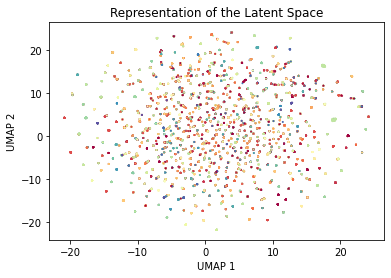

In [ ]:
import umap

n_samples = 20000

latent = np.array(data_embeddings)[:n_samples]
print(latent.shape)

unique_labels = list(np.unique(data_labels[:n_samples]))
# print(unique_labels)
# print(len(unique_labels))
# 

y_true = np.array(list(map(lambda x: unique_labels.index(x), data_labels[:n_samples])))


fig, ax = plt.subplots(nrows=1, ncols=1) 
ax.set_title("Representation of the Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

_embedding = umap.UMAP(random_state=42).fit_transform(latent)
print(_embedding.shape)

ax.scatter(_embedding[:, 0],
           _embedding[:, 1],
           c=y_true,
           s=1,
           cmap='Spectral')
plt.show()


In [ ]:
# unique_labels.index(data_labels[20000])

In [ ]:
## Histogram of Nearest Neighbors
from sklearn.neighbors import NearestNeighbors


metrics = ['manhattan', 'cosine', 'minkowski']
scores = []
neighbour_size = 1
gt = y_true
for metric in metrics:
    nbrs = NearestNeighbors(n_neighbors=neighbour_size+1, metric=metric).fit(latent)
    _, neighbour_indices = nbrs.kneighbors(latent)
    neighbour_indices = neighbour_indices.astype(np.int32)[:,1:]
    
    y_neighbors = gt[neighbour_indices]

    y_mode = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y_neighbors)
    scores.append(np.sum(y_mode == gt)/n_samples)

print(scores)
print("Best Metric: ", metrics[scores.index(max(scores))], "Accuracy: ", max(scores))
best_metric = metrics[scores.index(max(scores))]

[0.6896, 0.01605, 0.07855]
Best Metric:  manhattan Accuracy:  0.6896


## Embedding [GAP]

In [ ]:
class BART():
  def __init__(self, x,y):
    self.x = x
    self.y = y
  
  def sum(self, z):
    out = z + self.x + self.y
    return out 

quesito = BART(2,4)
print(quesito.sum(10))

class CLS_BART(BART):
    def __init__(self, x, y):
        super(CLS_BART, self).__init__(x,y)
    
    def sum(self, z):
      out = z + self.x + self.y
      return out, z 

quesito = CLS_BART(2,4)
print(quesito.sum(10))



class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, n_layers, d_k, d_v, n_heads, device):
        super(BERT, self).__init__(vocab_size, d_model, maxlen, n_segments, n_layers, d_k, d_v, n_heads, device)

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            # embedding layer
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # classifier pos/neg (it will be decided by first token(CLS))
        h_pooled = self.activ1(self.fc(output[:, 0]))  # [batch_size, d_model]
        
        
        
        logits_clsf = self.classifier(h_pooled)  # [batch_size, 2]

        # classifier mask
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))  # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos)  # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias  # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf, output

## Embedding [MAP]